# Machine Learning in Crowd Modelling and Simulation
# Final Project
# Task 5: EDMD on Crowd Dynamics

### Group M:
1. Muhammad Waleed Bin Khalid
2. Qais Hamarneh
3. Yiming Zhang

# Useful Imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from EDMD import EDMD
from tqdm import tqdm
from io import StringIO
from Observables import *
from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Trajectory Dataset

In [2]:
with open('data/postvis.traj') as f:
    lines = f.read()
ped_traj_df = pd.read_csv(StringIO(lines), sep=' ')
ped_traj_df

,pedestrianId,simTime,endTime-PID1,startX-PID1,startY-PID1,endX-PID1,endY-PID1,targetId-PID2
0,1,0.400000,0.957365,5.890973,4.204623,6.312940,4.166664,4
1,2,0.400000,1.033053,8.607234,7.263299,9.384863,7.601927,4
2,3,0.400000,1.117193,1.973335,2.212365,2.630341,2.376340,4
3,4,0.400000,1.178352,7.635275,3.410553,7.958087,3.439929,4
4,5,0.400000,1.033995,6.186206,3.221315,6.669568,2.889827,4
...,...,...,...,...,...,...,...,...
5144,74,54.851343,55.587172,26.442616,5.142354,27.111536,5.142354,4
5145,43,55.033973,55.814458,24.584583,5.258363,25.211121,5.258363,4
5146,43,55.814458,56.594944,25.211121,5.258363,25.837659,5.258363,4
5147,43,56.594944,57.375429,25.837659,5.258363,26.464197,5.258363,4


In [3]:
print(f"Delta t is {np.diff(ped_traj_df[ped_traj_df.pedestrianId == 1].simTime.to_numpy())[0]:0.4f}")

Delta t is 0.5574


In [4]:
ped_traj_df_formatted = format_traj_df(ped_traj_df)
ped_traj_df_formatted

,ID,x1,x2,y1,y2
0,1,5.890973,4.204623,6.312940,4.166664
1,2,8.607234,7.263299,9.384863,7.601927
2,3,1.973335,2.212365,2.630341,2.376340
3,4,7.635275,3.410553,7.958087,3.439929
4,5,6.186206,3.221315,6.669568,2.889827
...,...,...,...,...,...
5144,74,26.442616,5.142354,27.111536,5.142354
5145,43,24.584583,5.258363,25.211121,5.258363
5146,43,25.211121,5.258363,25.837659,5.258363
5147,43,25.837659,5.258363,26.464197,5.258363


# Actual Pedestrian Trajectories

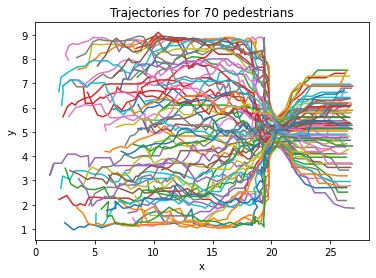

In [5]:
def plot_trajectories(traj_df: pd.DataFrame, no_peds: int, ax):
    for ped in range(no_peds+1):
        df = traj_df[traj_df.ID == ped]
        ax.plot(df.x1.to_numpy(), df.x2.to_numpy())
    ax.set_xlabel('x'), ax.set_ylabel('y'), ax.set_title(f"Trajectories for {no_peds} pedestrians")


fig, ax = plt.subplots()
plot_trajectories(ped_traj_df_formatted, 70, ax)

# Equal Data

Since we need equal data for each pedestrian, pedestrians that reach the target early have the same position appended until their data count is same as the latest pedestrian. The assumption here is that pedestrians simply stop on reaching the target.

In [6]:
ped_traj_df_formatted.groupby('ID').count().head()

,x1,x2,y1,y2
ID,,,,
1,47,47,47,47
2,36,36,36,36
3,63,63,63,63
4,54,54,54,54
5,43,43,43,43


In [10]:
# def append_end_loc_to_ped_traj(traj_df_formatted: pd.DataFrame):
#     max_steps = traj_df_formatted.groupby('ID').count().iloc[:,1].max()
#     for ped in list(traj_df_formatted.ID.unique()):
#         df = traj_df_formatted[traj_df_formatted.ID == ped]
#         curr_steps = len(df)
#         if curr_steps < max_steps:
#             last_loc = df.iloc[-1,:].to_numpy()
#             df_to_append = pd.DataFrame(np.tile(last_loc, (max_steps - curr_steps, 1)), columns=list(traj_df_formatted.columns))
#             traj_df_formatted = traj_df_formatted.append(df_to_append)
#     traj_df_formatted.reset_index(drop=True, inplace=True)
#     return traj_df_formatted

# def remove_end_loc_to_ped_traj(traj_df: pd.DataFrame):
#     min_steps = traj_df.groupby('ID').count().iloc[:,1].min()
#     traj_df_formatted = pd.DataFrame()
#     for ped in list(traj_df.ID.unique()):
#         df = traj_df[traj_df.ID == ped]
#         curr_steps = len(df)
#         if curr_steps > min_steps:
#             df.reset_index(drop=True, inplace=True)
#             df = df.drop(range(min_steps, len(df)))
#             traj_df_formatted = traj_df_formatted.append(df)
#     traj_df_formatted.reset_index(drop=True, inplace=True)
#     return traj_df_formatted

ped_traj_df_formatted_reduced = remove_end_loc_to_ped_traj(ped_traj_df_formatted)
ped_traj_df_formatted_reduced.groupby('ID').count().head()

,x1,x2,y1,y2
ID,,,,
1,22,22,22,22
2,22,22,22,22
3,22,22,22,22
4,22,22,22,22
5,22,22,22,22


# Finding Center of Gravity from Actual Data

In [11]:
center_of_gravity = find_center_of_gravity(ped_traj_df_formatted_reduced)

22


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 16.15it/s]


(Text(0.5, 0, 'x'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Center of Gravity'))

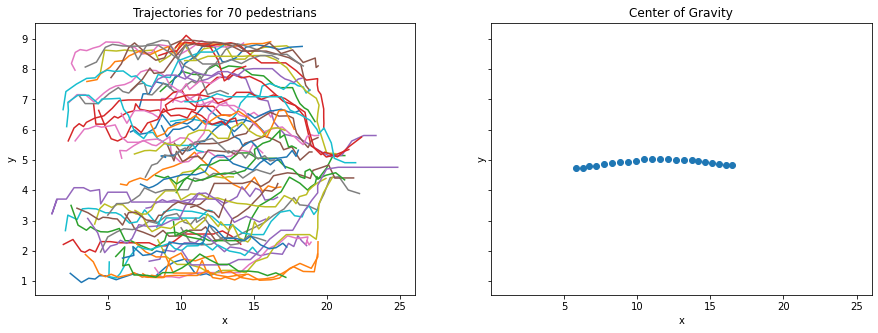

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
plot_trajectories(ped_traj_df_formatted_reduced, 70, axs[0])
axs[1].scatter(center_of_gravity[:,0], center_of_gravity[:,1])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Center of Gravity")

# Applying EDMD with Polynomial Dictionary of Observables

In [13]:
polynomial_observables = Polynomials(5)
polynomial_observables.fit(ped_traj_df_formatted_reduced.iloc[:,0:3])
polynomial_observables.segregate_observables_from_variable(polynomial_observables.fit(ped_traj_df_formatted_reduced.iloc[:,0:3]))

,ID,x1,x2,x1^0x2^1,x1^0x2^2,x1^0x2^3,x1^0x2^4,x1^0x2^5,x1^1x2^0,x1^1x2^1,...,x1^2x2^0,x1^2x2^1,x1^2x2^2,x1^2x2^3,x1^3x2^0,x1^3x2^1,x1^3x2^2,x1^4x2^0,x1^4x2^1,x1^5x2^0
0,1,5.890973,4.204623,4.204623,17.678859,74.332944,312.542042,1314.121608,5.890973,24.769322,...,34.703560,145.915403,613.519329,2579.617776,204.437726,859.583661,3614.225646,1204.337070,5063.783923,7094.716857
1,1,6.312940,4.166664,4.166664,17.361089,72.337828,301.407428,1255.863498,6.312940,26.303899,...,39.853209,166.054934,691.895125,2882.894558,251.590908,1048.294799,4367.892272,1588.278259,6617.821954,10026.705031
2,1,6.462486,4.266361,4.266361,18.201839,77.655624,331.306955,1413.475192,6.462486,27.571300,...,41.763722,178.179130,760.176557,3243.187897,269.897458,1151.480089,4912.630166,1744.208476,7441.423659,11271.922413
3,1,6.761686,4.326681,4.326681,18.720168,80.996197,350.444709,1516.262463,6.761686,29.255658,...,45.720398,197.817577,855.893554,3703.178380,309.146976,1337.580350,5787.283488,2090.354792,9044.298366,14134.322796
4,1,7.226400,4.403866,4.403866,19.394040,85.408761,376.128778,1656.420907,7.226400,31.824101,...,52.220859,229.973689,1012.773415,4460.118868,377.368823,1661.881900,7318.705949,2727.018114,12009.423593,19706.524084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151,100,10.588116,1.782405,1.782405,3.176967,5.662643,10.093122,17.990031,10.588116,18.872310,...,112.108194,199.822202,356.164084,634.828630,1187.014536,2115.740597,3771.106536,12568.247262,22401.706270,133074.056375
2152,100,11.237721,1.922595,1.922595,3.696371,7.106625,13.663162,26.268727,11.237721,21.605586,...,126.286379,242.797558,466.801366,897.469962,1419.171120,2728.491271,5245.783621,15948.249434,30662.024304,179221.981391
2153,100,11.902282,1.922595,1.922595,3.696371,7.106625,13.663162,26.268727,11.902282,22.883267,...,141.664309,272.363090,523.643909,1006.755151,1686.128511,3241.742211,6232.557302,20068.776480,38584.128919,238864.230584
2154,100,12.566842,1.922595,1.922595,3.696371,7.106625,13.663162,26.268727,12.566842,24.160948,...,157.925521,303.626813,583.751387,1122.317487,1984.625085,3815.630226,7335.911520,24940.470104,47950.422625,313422.950071


In [14]:
edmd = EDMD(ped_traj_df_formatted_reduced, 2, polynomial_observables)
edmd.fit()

In [27]:
initial_values = ped_traj_df_formatted.groupby('ID').first().iloc[:,:2]
initial_values.insert(0,'ID',initial_values.index)
initial_values
traj_pred = edmd.predict(initial_values, t_end=30)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


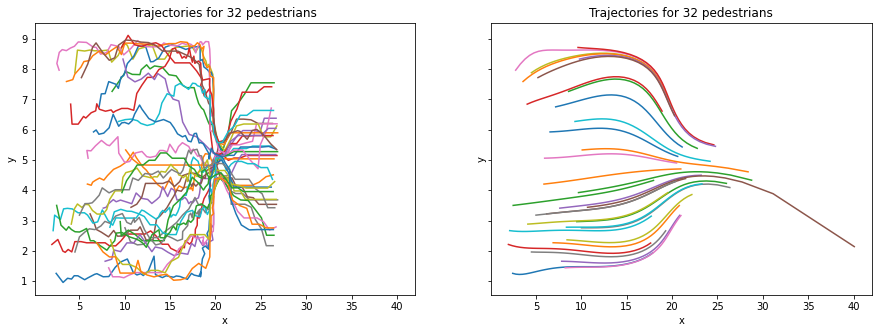

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
no_peds = 32
plot_trajectories(ped_traj_df_formatted, no_peds, axs[0])
plot_trajectories(traj_pred, no_peds, axs[1])

22


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 18.90it/s]


32


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 18.54it/s]


MSE of center of gravity is 0.30193


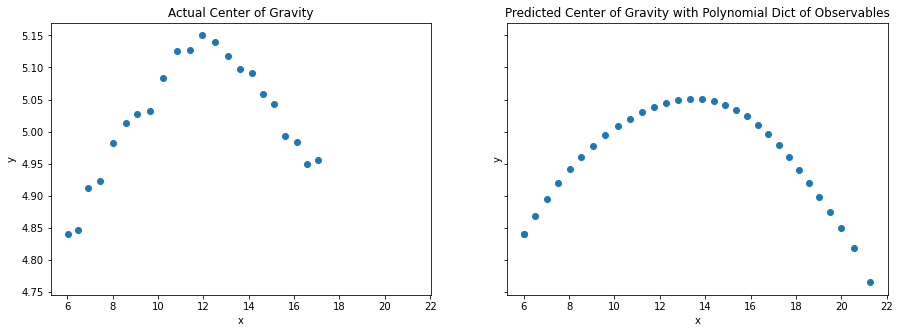

In [31]:
center_of_gravity = find_center_of_gravity(ped_traj_df_formatted)
center_of_gravity_edmd = find_center_of_gravity(traj_pred)
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
axs[0].scatter(center_of_gravity[:,0], center_of_gravity[:,1])
axs[0].set_xlabel('x'), axs[0].set_ylabel('y'), axs[0].set_title("Actual Center of Gravity")
axs[1].scatter(center_of_gravity_edmd[:,0], center_of_gravity_edmd[:,1])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Predicted Center of Gravity with Polynomial Dict of Observables")
print(f"MSE of center of gravity is {np.sum((center_of_gravity - center_of_gravity_edmd[:center_of_gravity.shape[0],:])**2) / center_of_gravity_edmd.shape[0]:0.5f}")

# Applying EDMD with Identity Dictionary of Observables

In [34]:
identity_observables = Identity()
identity_observables.fit(ped_traj_df_formatted_reduced.iloc[:,0:3])
edmd_identity = EDMD(ped_traj_df_formatted_reduced, 2, identity_observables)
edmd_identity.fit()
traj_pred_identity = edmd_identity.predict(initial_values, t_end=20)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.02it/s]


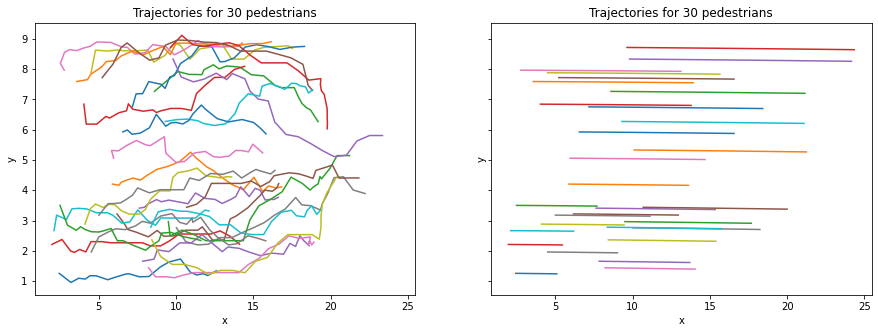

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
no_peds = 30
plot_trajectories(ped_traj_df_formatted_reduced, no_peds, axs[0])
plot_trajectories(traj_pred_identity, no_peds, axs[1])

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 21.31it/s]


MSE of center of gravity is 3.82248


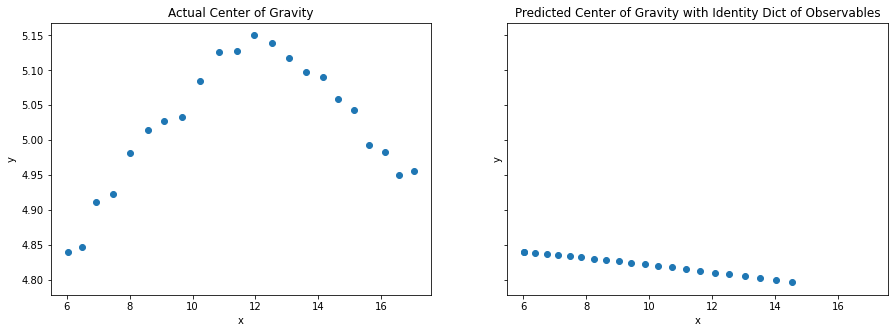

In [36]:
center_of_gravity_edmd_identity = find_center_of_gravity(traj_pred_identity)
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
axs[0].scatter(center_of_gravity[:,0], center_of_gravity[:,1])
axs[0].set_xlabel('x'), axs[0].set_ylabel('y'), axs[0].set_title("Actual Center of Gravity")
axs[1].scatter(center_of_gravity_edmd_identity[:,0], center_of_gravity_edmd_identity[:,1])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Predicted Center of Gravity with Identity Dict of Observables")
print(f"MSE of center of gravity is {np.sum((center_of_gravity - center_of_gravity_edmd_identity[:center_of_gravity.shape[0],:])**2) / center_of_gravity_edmd_identity.shape[0]:0.5f}")